In [1]:
import copy
import collections
import itertools
import concurrent.futures
import os.path
import pathlib
from typing import Any, Sequence, Mapping

In [2]:
from gym_electric_motor import reward_functions
import pandas as pd
import numpy as np
import tensorflow as tf
import ray

In [3]:
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt

In [4]:
from drmdp import feats, task
from drmdp.envs import gem

In [5]:
import warnings # To suppress some warnings
# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

## Control: Obs: Concat(Ref State, $\Delta$ Ref State)

In [6]:
def load_data(paths: Sequence[str]):
    dfs = []
    for path in paths:
        with tf.io.gfile.GFile(path, "r") as readable:
            dfs.append(pd.read_json(readable, orient="records", lines=True))
    return pd.concat(dfs)

In [7]:
df_result = load_data(
    tf.io.gfile.glob(os.path.join(pathlib.Path.home(), "fs/drmdp/exp/emotor/1744733696/*.jsonl"))
)

In [8]:
df_result

,env_name,feats_spec,policy,turn,episode,returns,steps
0,Finite-CC-SeriesDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,0,4800.303029,2500
1,Finite-CC-SeriesDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,1,4757.778377,2500
2,Finite-CC-SeriesDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,2,4743.503766,2500
3,Finite-CC-SeriesDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,3,4737.497331,2500
4,Finite-CC-SeriesDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,4,4708.359374,2500
...,...,...,...,...,...,...,...
295,Finite-SC-ShuntDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,295,552.256301,991
296,Finite-SC-ShuntDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,296,562.574764,2359
297,Finite-SC-ShuntDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,297,561.637823,148
298,Finite-SC-ShuntDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,298,574.007775,2253


In [9]:
def process_results(df_input):
    # averane at each poit in time
    def tfx_method(feats_spec):
        name = feats_spec["name"]
        if feats_spec["args"] is not None:
            kwargs = feats_spec["args"]
            # first char, value
            values = [f"{key[0]}:{str(value)}" for key, value in sorted(kwargs.items())]
            suffix = "/".join(values)
        else:
            suffix = "-"
        return f"{name}({suffix})"

    def control_type(name: str):
        if "-TC-" in name:
            return "Torque"
        elif "-CC-" in name:
            return "Current"
        elif "-SC-" in name:
            return "Speed"
        raise ValueError(f"Unknown control type: {name}")

                
        
    df_out = copy.deepcopy(df_input)
    df_out["feat_method"] = df_out["feats_spec"].apply(tfx_method)
    df_out["spec"] = df_out["policy"] + "/" + df_out["feat_method"]
    df_out["control_type"] = df_out["env_name"].apply(control_type)
    return df_out

In [10]:
df_proc_result = process_results(df_result)

In [11]:
df_proc_result

,env_name,feats_spec,policy,turn,episode,returns,steps,feat_method,spec,control_type
0,Finite-CC-SeriesDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,0,4800.303029,2500,spliced-tiles(t:3),markovian/spliced-tiles(t:3),Current
1,Finite-CC-SeriesDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,1,4757.778377,2500,spliced-tiles(t:3),markovian/spliced-tiles(t:3),Current
2,Finite-CC-SeriesDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,2,4743.503766,2500,spliced-tiles(t:3),markovian/spliced-tiles(t:3),Current
3,Finite-CC-SeriesDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,3,4737.497331,2500,spliced-tiles(t:3),markovian/spliced-tiles(t:3),Current
4,Finite-CC-SeriesDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,4,4708.359374,2500,spliced-tiles(t:3),markovian/spliced-tiles(t:3),Current
...,...,...,...,...,...,...,...,...,...,...
295,Finite-SC-ShuntDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,295,552.256301,991,spliced-tiles(t:3),markovian/spliced-tiles(t:3),Speed
296,Finite-SC-ShuntDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,296,562.574764,2359,spliced-tiles(t:3),markovian/spliced-tiles(t:3),Speed
297,Finite-SC-ShuntDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,297,561.637823,148,spliced-tiles(t:3),markovian/spliced-tiles(t:3),Speed
298,Finite-SC-ShuntDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,298,574.007775,2253,spliced-tiles(t:3),markovian/spliced-tiles(t:3),Speed


In [12]:
df_proc_result["control_type"].unique()

array(['Current', 'Torque', 'Speed'], dtype=object)

In [13]:
df_proc_result[df_proc_result["env_name"] == "Finite-CC-SCIM-v0"]["spec"].unique()

array(['markovian/tiles(t:2)', 'markovian/spliced-tiles(t:3)',
       'markovian/tiles(t:4)', 'markovian/tiles(t:3)',
       'uniform-random/identity(-)', 'markovian/spliced-tiles(t:4)',
       'markovian/scale(-)', 'markovian/spliced-tiles(t:2)'], dtype=object)

In [14]:
def plot_returns(df_input, control_type):
    df_slice = df_input[df_input["control_type"] == control_type]
    envs = sorted(df_slice["env_name"].unique())
    ncols = len(envs)
    fig, axes = plt.subplots(ncols=ncols, figsize=(5*ncols, 5))
    hue_order = sorted(df_slice["spec"].unique())

    for env, ax in zip(envs, axes.flatten()):
        df_plot = df_slice[df_slice["env_name"] == env]
        sns.lineplot(data=df_plot, x="episode", y="returns", hue="spec", hue_order=hue_order, ax=ax)
        ax.set_title(env)
        ax.set_ylabel("Episode")
        ax.set_xlabel("Returns")

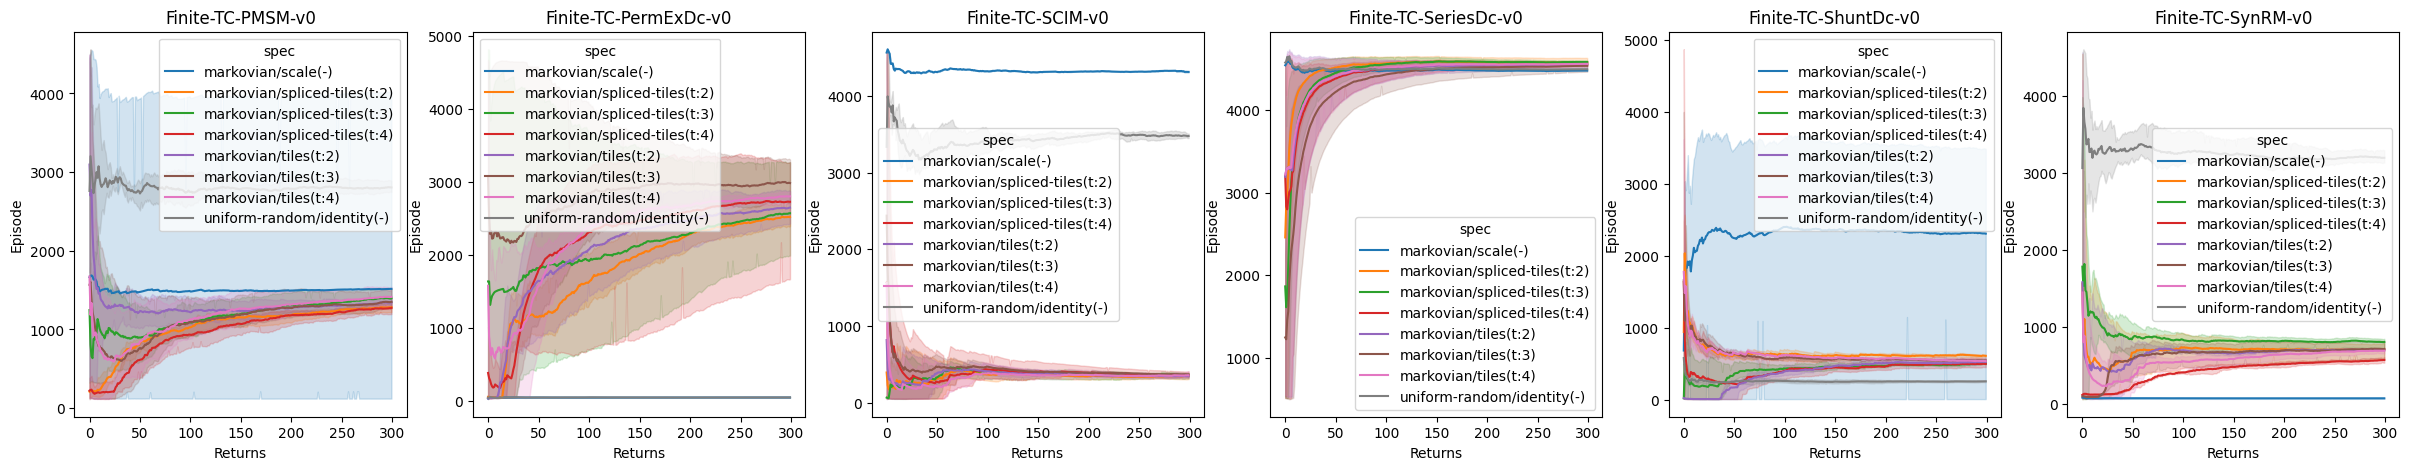

In [15]:
plot_returns(df_proc_result, "Torque")

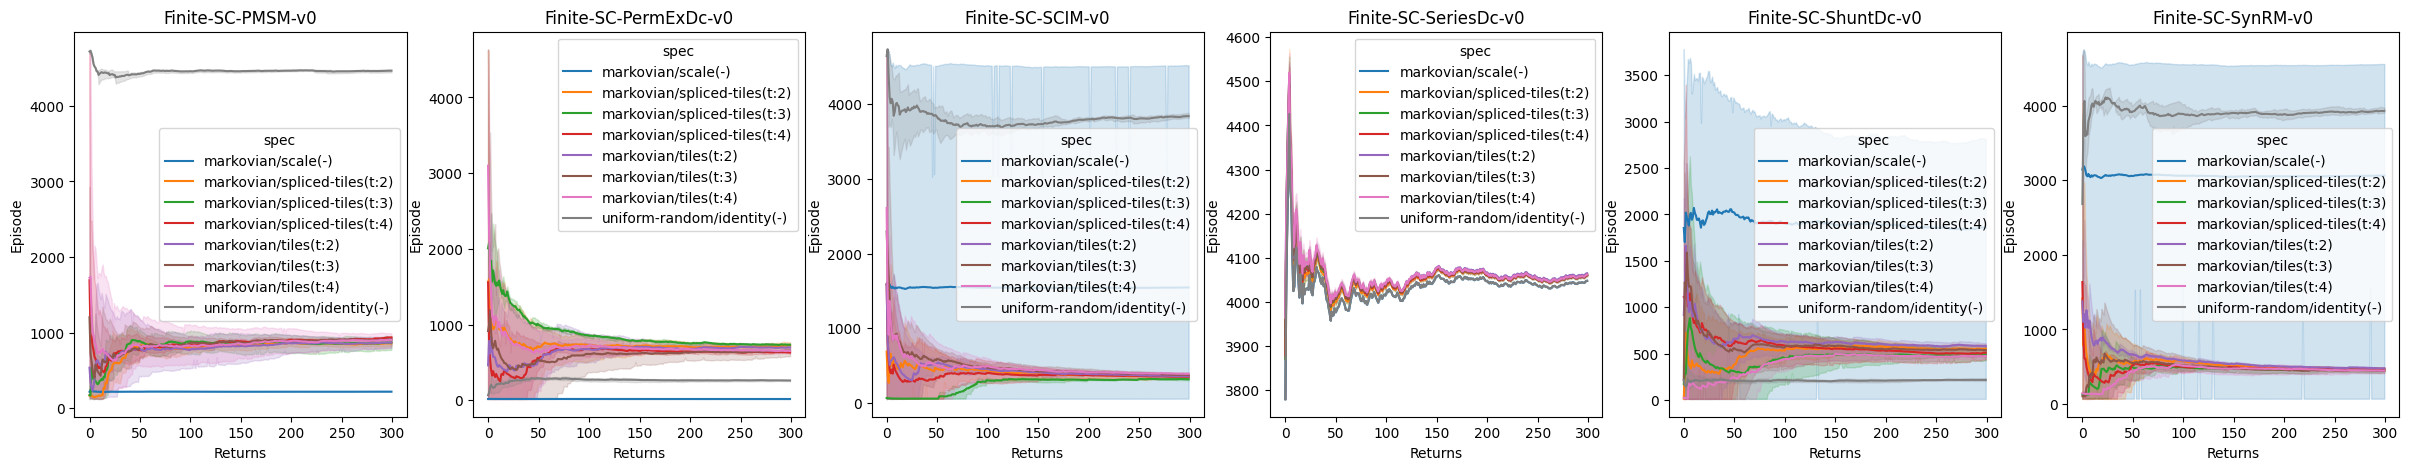

In [16]:
plot_returns(df_proc_result, "Speed")

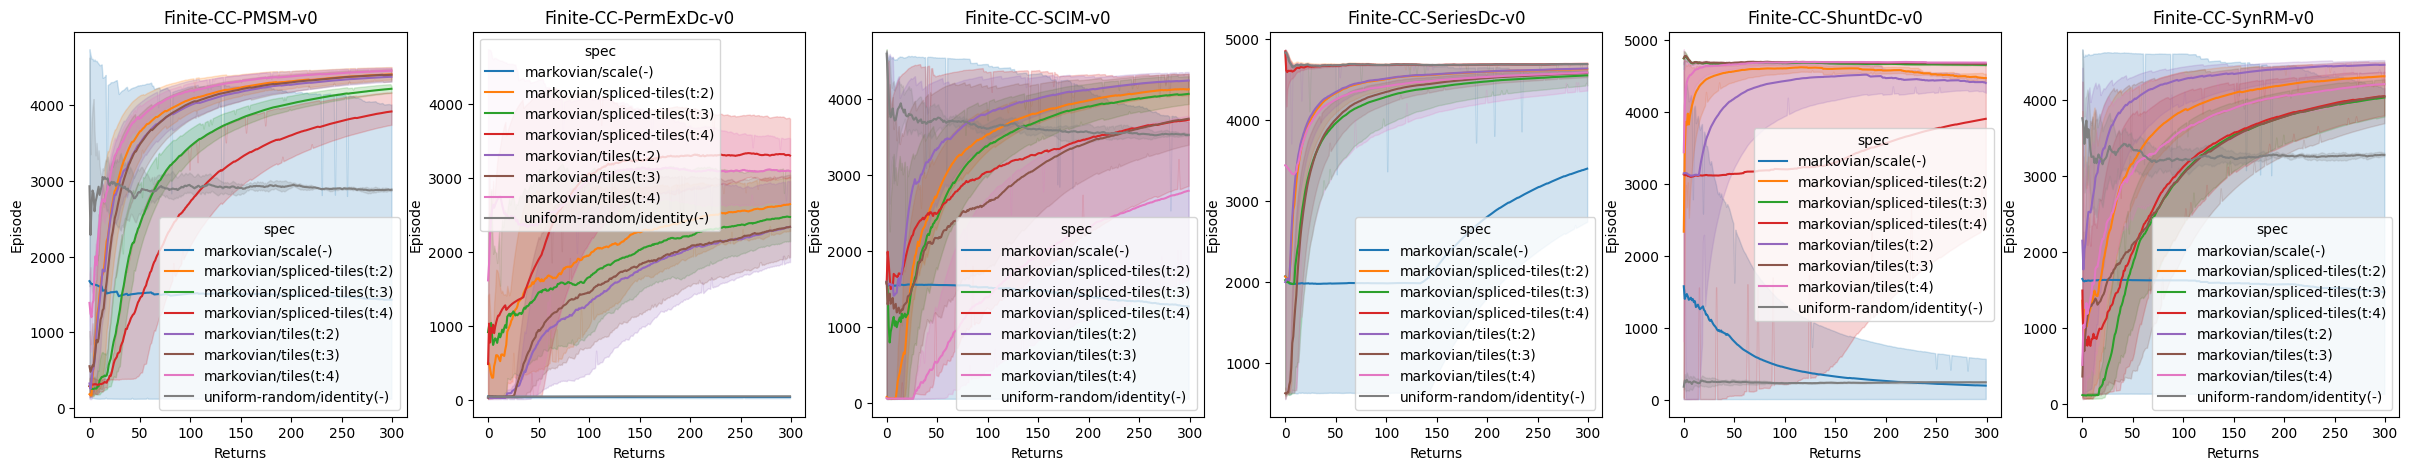

In [17]:
plot_returns(df_proc_result, "Current")

In [18]:
df_proc_result

,env_name,feats_spec,policy,turn,episode,returns,steps,feat_method,spec,control_type
0,Finite-CC-SeriesDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,0,4800.303029,2500,spliced-tiles(t:3),markovian/spliced-tiles(t:3),Current
1,Finite-CC-SeriesDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,1,4757.778377,2500,spliced-tiles(t:3),markovian/spliced-tiles(t:3),Current
2,Finite-CC-SeriesDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,2,4743.503766,2500,spliced-tiles(t:3),markovian/spliced-tiles(t:3),Current
3,Finite-CC-SeriesDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,3,4737.497331,2500,spliced-tiles(t:3),markovian/spliced-tiles(t:3),Current
4,Finite-CC-SeriesDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,4,4708.359374,2500,spliced-tiles(t:3),markovian/spliced-tiles(t:3),Current
...,...,...,...,...,...,...,...,...,...,...
295,Finite-SC-ShuntDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,295,552.256301,991,spliced-tiles(t:3),markovian/spliced-tiles(t:3),Speed
296,Finite-SC-ShuntDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,296,562.574764,2359,spliced-tiles(t:3),markovian/spliced-tiles(t:3),Speed
297,Finite-SC-ShuntDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,297,561.637823,148,spliced-tiles(t:3),markovian/spliced-tiles(t:3),Speed
298,Finite-SC-ShuntDc-v0,"{'name': 'spliced-tiles', 'args': {'tiling_dim...",markovian,1,298,574.007775,2253,spliced-tiles(t:3),markovian/spliced-tiles(t:3),Speed


In [19]:
def top_results(df_input, topn: int):
    max_episode = df_input["episode"].max()
    df_slice = copy.deepcopy(df_input[(df_input["episode"] == max_episode)])
    # Aggregate returns across runs
    df_slice = df_slice[["env_name", "spec", "returns"]]
    df_agg = df_slice.groupby(
        ["env_name", "spec"]
    ).mean("returns").reset_index()

    dfs = []
    for group, df in df_agg.groupby(["env_name"]):
        # compare each spec against uniform-random
        ref_result = df[
            df["spec"].apply(lambda spec: "uniform-random" in spec)
        ].to_dict(orient="records")[0]
        df_group = copy.deepcopy(df)
        df_group["returns_ratio"] = (df_group["returns"] - ref_result["returns"])/ref_result["returns"]        
        dfs.append(df_group.nlargest(topn, "returns"))
    return pd.concat(dfs)

In [20]:
df_env_topn = top_results(df_proc_result, topn=3)

In [21]:
df_env_topn

,env_name,spec,returns,returns_ratio
6,Finite-CC-PMSM-v0,markovian/tiles(t:4),4453.284868,0.545974
1,Finite-CC-PMSM-v0,markovian/spliced-tiles(t:2),4404.722522,0.529115
5,Finite-CC-PMSM-v0,markovian/tiles(t:3),4399.779779,0.527399
11,Finite-CC-PermExDc-v0,markovian/spliced-tiles(t:4),3303.073273,66.491799
14,Finite-CC-PermExDc-v0,markovian/tiles(t:4),3091.530809,62.169345
9,Finite-CC-PermExDc-v0,markovian/spliced-tiles(t:2),2646.353985,53.073033
20,Finite-CC-SCIM-v0,markovian/tiles(t:2),4243.193080,0.202676
17,Finite-CC-SCIM-v0,markovian/spliced-tiles(t:2),4128.199155,0.170082
18,Finite-CC-SCIM-v0,markovian/spliced-tiles(t:3),4067.911070,0.152994
27,Finite-CC-SeriesDc-v0,markovian/spliced-tiles(t:4),4690.536828,0.000487


In [22]:
# envs where uniform-random isn't top n
def linearly_solvable_envs(df_input):
    dfs = []
    for env, df in df_input.groupby(["env_name"]):
        specs = set(df["spec"].unique())
        if any(["uniform-random" in spec for spec in specs]):
            continue
        dfs.append(df)
    return pd.concat(dfs)

In [23]:
df_linearly_solvable = linearly_solvable_envs(df_env_topn)

In [24]:
df_linearly_solvable

,env_name,spec,returns,returns_ratio
6,Finite-CC-PMSM-v0,markovian/tiles(t:4),4453.284868,0.545974
1,Finite-CC-PMSM-v0,markovian/spliced-tiles(t:2),4404.722522,0.529115
5,Finite-CC-PMSM-v0,markovian/tiles(t:3),4399.779779,0.527399
11,Finite-CC-PermExDc-v0,markovian/spliced-tiles(t:4),3303.073273,66.491799
14,Finite-CC-PermExDc-v0,markovian/tiles(t:4),3091.530809,62.169345
9,Finite-CC-PermExDc-v0,markovian/spliced-tiles(t:2),2646.353985,53.073033
20,Finite-CC-SCIM-v0,markovian/tiles(t:2),4243.193080,0.202676
17,Finite-CC-SCIM-v0,markovian/spliced-tiles(t:2),4128.199155,0.170082
18,Finite-CC-SCIM-v0,markovian/spliced-tiles(t:3),4067.911070,0.152994
38,Finite-CC-ShuntDc-v0,markovian/tiles(t:4),4688.366726,17.907855


In [25]:
def top_spec(df_input, topn: int):
    df_slice = copy.deepcopy(df_input)
    # Aggregate returns across runs
    dfs = []
    for group, df in df_slice.groupby(["env_name"]):
        # compare each spec against uniform-random
        dfs.append(df.nlargest(topn, "returns"))
    return pd.concat(dfs)

In [26]:
top_spec(df_linearly_solvable, topn=1)

,env_name,spec,returns,returns_ratio
6,Finite-CC-PMSM-v0,markovian/tiles(t:4),4453.284868,0.545974
11,Finite-CC-PermExDc-v0,markovian/spliced-tiles(t:4),3303.073273,66.491799
20,Finite-CC-SCIM-v0,markovian/tiles(t:2),4243.193080,0.202676
38,Finite-CC-ShuntDc-v0,markovian/tiles(t:4),4688.366726,17.907855
44,Finite-CC-SynRM-v0,markovian/tiles(t:2),4467.969791,0.362726
58,Finite-SC-PermExDc-v0,markovian/spliced-tiles(t:3),733.174307,1.816666
76,Finite-SC-SeriesDc-v0,markovian/tiles(t:2),4064.575619,0.004197
80,Finite-SC-ShuntDc-v0,markovian/scale(-),1857.603687,7.515485
109,Finite-TC-PermExDc-v0,markovian/tiles(t:3),2986.292251,59.029081
122,Finite-TC-SeriesDc-v0,markovian/spliced-tiles(t:3),4578.784548,0.019387
